<a href="https://colab.research.google.com/github/q1ngyM/Github_Colab/blob/main/Dict/mlp_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation as animator

In [ ]:
# 下载训练数据
train_data = datasets.MNIST(
    root = "./drive/MyDrive/data",
    train = True,
    download=True,
    transform=ToTensor(),
)

# 下载测试数据
test_data = datasets.MNIST(
    root="./drive/MyDrive/data",
    train=False,
    download=True,
    transform=ToTensor(),
)

print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16196194.10it/s]


Extracting ./drive/MyDrive/data/MNIST/raw/train-images-idx3-ubyte.gz to ./drive/MyDrive/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 489148.60it/s]


Extracting ./drive/MyDrive/data/MNIST/raw/train-labels-idx1-ubyte.gz to ./drive/MyDrive/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4445114.51it/s]


Extracting ./drive/MyDrive/data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./drive/MyDrive/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9050132.43it/s]

Extracting ./drive/MyDrive/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./drive/MyDrive/data/MNIST/raw

Number of training examples: 60000
Number of testing examples: 10000


In [ ]:
batch_size = 64

# 创建数据加载器
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [B, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


Shape of X [B, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [ ]:
# 选择训练设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cpu device


In [ ]:
# 创建MLP模型
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, 250),
            nn.ReLU()
        )

        self.hidden_layer = nn.Sequential(
            nn.Linear(250, 100),
            nn.ReLU()
        )

        self.output_layer = nn.Sequential(
            nn.Linear(100, output_dim)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        return x

model = MLP(28*28, 10).to(device)
print(model)


MLP(
  (input_layer): Sequential(
    (0): Linear(in_features=784, out_features=250, bias=True)
    (1): ReLU()
  )
  (hidden_layer): Sequential(
    (0): Linear(in_features=250, out_features=100, bias=True)
    (1): ReLU()
  )
  (output_layer): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# 在训练过程中更新动态图表
def train(dataloader, model, loss_fn, optimizer, num_epochs,train_losses,train_accuracies):
    train_loss, train_acc = train_step(dataloader, model, loss_fn, optimizer, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    return train_losses, train_accuracies


# 单个训练步骤
def train_step(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy
        _, predicted = torch.max(pred, 1)
        correct += (predicted == y).sum().item()

    train_loss /= size
    train_acc = correct / size
    return train_loss, train_acc


In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f'Testing Loss: {test_loss:.4f}, Testing Accuracy: {correct:.4f}')


In [ ]:
epochs = 5
epoch = []
train_loss = []
train_acc = []
for t in range(epochs):
    epoch.append(t)
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer, epochs,train_loss, train_acc)
    test(test_dataloader,model,loss_fn)



Testing Loss: 0.1459, Testing Accuracy: 0.9542
Testing Loss: 0.1054, Testing Accuracy: 0.9666
Testing Loss: 0.1221, Testing Accuracy: 0.9629
Testing Loss: 0.1158, Testing Accuracy: 0.9653
Testing Loss: 0.0897, Testing Accuracy: 0.9751


In [ ]:
def update_plot(frame, epochs, train_losses, train_accuracies):
    plt.figure()
    plt.plot(epochs[:frame], train_losses[:frame], label='Train Loss')
    plt.plot(epochs[:frame], train_accuracies[:frame], label='Train Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Training Progress')
    plt.show

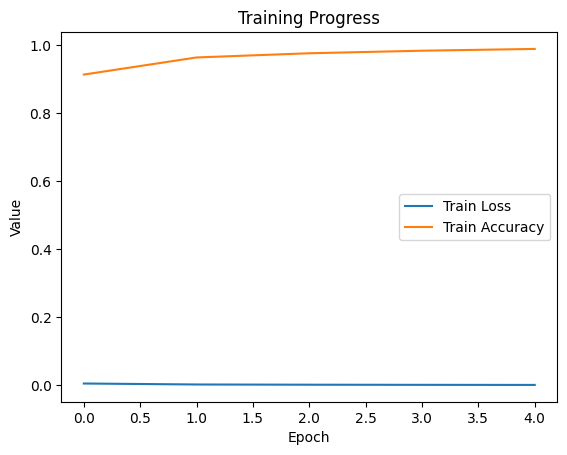

In [ ]:
update_plot(epochs, epoch, train_loss, train_acc)